# Базовое решение задачи kaggle "Classification of butterflies"

Описание задачи и данные:

https://www.kaggle.com/c/classification-of-butterflies/data

In [5]:
import re
import pandas as pd
import os

In [2]:
!pip install opendatasets
import opendatasets as od
od.download("https://www.kaggle.com/competitions/classification-of-butterflies/overview")

100%|██████████| 132M/132M [00:01<00:00, 96.7MB/s]



Extracting archive ./classification-of-butterflies/classification-of-butterflies.zip to ./classification-of-butterflies


In [3]:
os.chdir(r"classification-of-butterflies")

In [4]:
os.listdir(os.getcwd())

['train_butterflies', 'test_butterflies']

## Считывание данных

Для применения алгоритмов ML необходимо чтобы изображения были одного размера, но нам повезло по условию, они уже все одного размера

Метод фреймворка Tensorflow `image_dataset_from_directory` - Позволяет их картинок создать тренировочный набор данных, картинки размещены по разным папкам, что и является разметкой классов по сути

https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory

In [6]:
import tensorflow as tf

In [21]:
# считаем тренировочные данные

# 224 - ширина, 224 - высота, 3 - количество каналов (для цветных картинок RGB - значит 3 канала)
img_shape=(224,224,3)
validation_split = 0.3

# train_dir - путь до тренировочных данных
train_dir = os.path.join('train_butterflies/train_split')

img_size = (img_shape[0], img_shape[1])

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    validation_split = validation_split,
    subset = "training",
    seed=123,
    batch_size=15,
    shuffle=True)

valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=img_size,
    validation_split = validation_split,
    subset = "validation",
    seed=123,
    batch_size=15,
    shuffle=True)

Found 4955 files belonging to 50 classes.
Using 3469 files for training.
Found 4955 files belonging to 50 classes.
Using 1486 files for validation.


In [22]:
# train_ds - созданный набор тренировочных данных созданный с помощью Tensorflow
# class_names - метод объекта данных Tensorflow который возвращает список всех классов в виде списка
class_names = train_ds.class_names

# всего 50 классов, что мы собственно и видим после того как считали тренировочные данные
class_count = len(class_names)

In [23]:
# названия классов совпадают с названием папок
class_names

['class_0',
 'class_1',
 'class_10',
 'class_11',
 'class_12',
 'class_13',
 'class_14',
 'class_15',
 'class_16',
 'class_17',
 'class_18',
 'class_19',
 'class_2',
 'class_20',
 'class_21',
 'class_22',
 'class_23',
 'class_24',
 'class_25',
 'class_26',
 'class_27',
 'class_28',
 'class_29',
 'class_3',
 'class_30',
 'class_31',
 'class_32',
 'class_33',
 'class_34',
 'class_35',
 'class_36',
 'class_37',
 'class_38',
 'class_39',
 'class_4',
 'class_40',
 'class_41',
 'class_42',
 'class_43',
 'class_44',
 'class_45',
 'class_46',
 'class_47',
 'class_48',
 'class_49',
 'class_5',
 'class_6',
 'class_7',
 'class_8',
 'class_9']

InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:GPU:0}} slice index 15 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

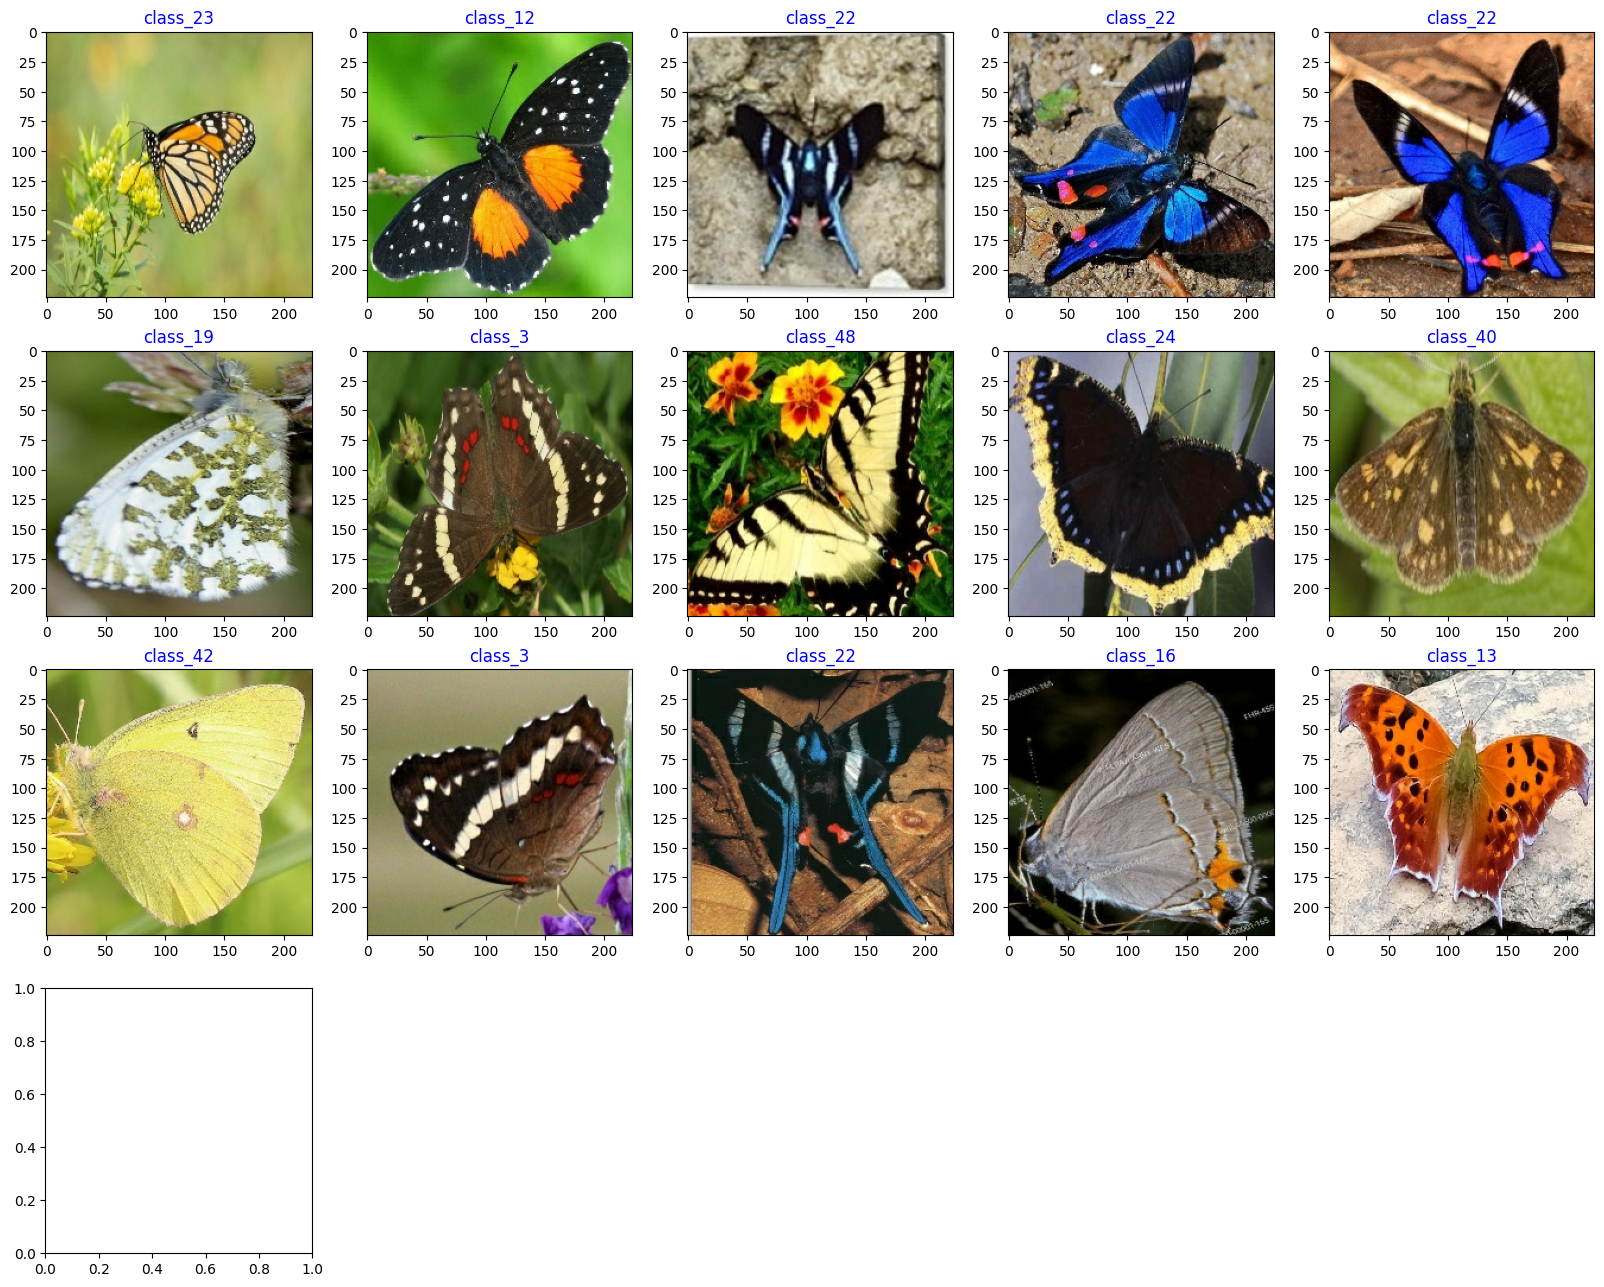

In [ ]:
# посмотрим на некоторые картинки из набора тренировочных данных
import matplotlib.pyplot as plt

plt.figure(figsize=(20,20))

for images, labels in train_ds.take(1):
    for i in range (25):
        plt.subplot(5,5,i +1)
        img=images[i]/255
        plt.title(class_names[labels[i]], color='blue', fontsize=12)
        plt.imshow(img)
    plt.show()

## Построение модели

**Слой `Input`**

Помимо функциональных слоев в Keras существуют вспомогательные слои и один из них определяется классом `Input`.

Как вы уже догадались, этот слой служит для описания формы входных данных. То есть, если модель не имеет слоя Input, то размерность входного вектора устанавливается по входному тензору при первом вызове.

Но, если явно указать размерность через класс Input, то модель сети строится сразу с начальным набором весов.

Нейронная сеть архитектуры **EfficientNetB3**, которая обучена на наборе данных UTKFace DataSet.

Возьмем готовую архитектуру для решения задачи (можете еще ResNet попробовать).

https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet/EfficientNetB3

`Model` - Модель это (обычно) граф слоев.


https://www.tensorflow.org/api_docs/python/tf/keras/Model

`Adamax` – вариант оптимизации по Adam, но без ограничений по норме.

Модели глубоко обучения

https://keras.io/api/applications/#xception

In [24]:
%%time
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, Adamax

input = Input(shape = img_shape)

x = tf.keras.applications.EfficientNetB3(include_top=False, weights="imagenet", pooling='max')(input)
# x = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)

x = Dropout(rate=.4, seed=123)(x)

output = Dense(class_count, activation='softmax')(x)

model = Model(inputs = input, outputs = output)

# model.compile(Adamax(lr=.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.compile(
    optimizer = Adamax(lr=.001),
    loss = tf.losses.SparseCategoricalCrossentropy(),
    # CategoricalCrossentropy()
    metrics = ['accuracy'])

history = model.fit(train_ds, validation_data = valid_ds, epochs = 4, verbose = 1)

43941136/43941136 [==============================] - 0s 0us/step


Epoch 1/4
232/232 [==============================] - 120s 283ms/step - loss: 2.8885 - accuracy: 0.4624 - val_loss: 0.4038 - val_accuracy: 0.8917
Epoch 2/4
232/232 [==============================] - 65s 282ms/step - loss: 0.4570 - accuracy: 0.8613 - val_loss: 0.2998 - val_accuracy: 0.9280
Epoch 3/4
232/232 [==============================] - 61s 261ms/step - loss: 0.2402 - accuracy: 0.9320 - val_loss: 0.3000 - val_accuracy: 0.9307
Epoch 4/4
232/232 [==============================] - 61s 263ms/step - loss: 0.1650 - accuracy: 0.9519 - val_loss: 0.2935 - val_accuracy: 0.9347
CPU times: user 4min 30s, sys: 10.8 s, total: 4min 41s
Wall time: 6min 41s


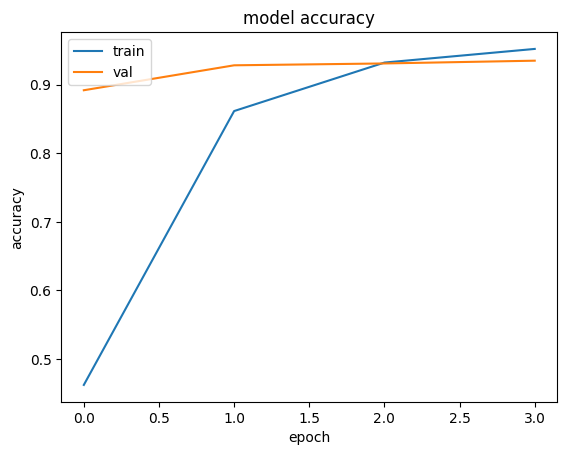

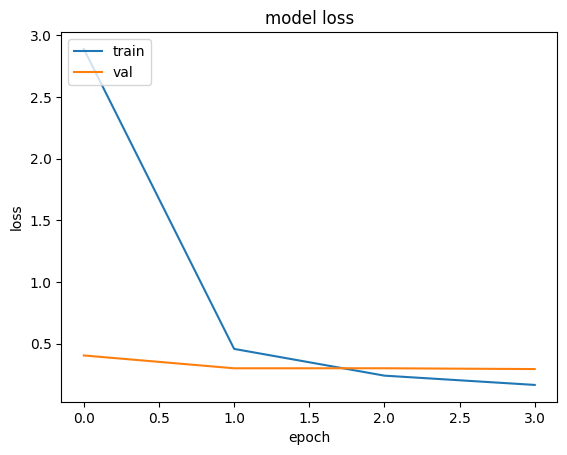

In [29]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# Предскажем значения для тестового набора данных
preds = model.predict(valid_ds, verbose=1)
preds

17/17 [==============================] - 6s 129ms/step


array([[4.63431832e-07, 4.76811977e-08, 1.01002335e-07, ...,
        2.14701731e-06, 1.27355736e-06, 8.77915269e-08],
       [2.58435582e-11, 8.04561279e-11, 2.74468902e-12, ...,
        1.57902053e-10, 5.79957360e-10, 7.36926076e-09],
       [1.85975263e-11, 8.45459380e-12, 1.06320258e-10, ...,
        8.15451179e-12, 8.50898258e-12, 1.13581605e-12],
       ...,
       [2.60008584e-08, 3.09407433e-08, 8.36988329e-05, ...,
        3.46107925e-07, 8.38678204e-07, 1.34338143e-06],
       [3.15172818e-11, 4.85205987e-10, 1.84854229e-10, ...,
        4.70294959e-09, 1.53774016e-09, 1.07475057e-10],
       [9.30628573e-07, 6.60174783e-06, 1.67900021e-06, ...,
        8.26125984e-07, 1.35103755e-05, 1.88796673e-06]], dtype=float32)

In [ ]:
import numpy as np

ypred = []
errors = 0
count = 0

for i, p in enumerate(preds):
    index = np.argmax(p)
    klass = class_names[index]
    ypred.append(klass)

ypred = np.array(ypred)

In [ ]:
ypred
# class_1

array(['class_27', 'class_49', 'class_22', 'class_28', 'class_3',
       'class_43', 'class_33', 'class_38', 'class_8', 'class_22',
       'class_42', 'class_28', 'class_0', 'class_20', 'class_43',
       'class_29', 'class_36', 'class_4', 'class_49', 'class_29',
       'class_15', 'class_12', 'class_11', 'class_0', 'class_32',
       'class_25', 'class_10', 'class_5', 'class_46', 'class_29',
       'class_2', 'class_28', 'class_34', 'class_18', 'class_34',
       'class_49', 'class_1', 'class_30', 'class_6', 'class_13',
       'class_23', 'class_0', 'class_14', 'class_42', 'class_44',
       'class_35', 'class_12', 'class_36', 'class_46', 'class_40',
       'class_11', 'class_25', 'class_49', 'class_13', 'class_43',
       'class_41', 'class_18', 'class_38', 'class_9', 'class_0',
       'class_24', 'class_38', 'class_18', 'class_26', 'class_41',
       'class_33', 'class_39', 'class_7', 'class_8', 'class_43',
       'class_33', 'class_16', 'class_41', 'class_19', 'class_21',
       'c

In [ ]:
df = pd.DataFrame(ypred, columns=['label'])
df['label'] = df['label'].str.replace(r"class_",'')
df['label'] = df['label'].astype(int)
df

,label
0,27
1,49
2,22
3,28
4,3
...,...
245,32
246,19
247,48
248,22


In [ ]:
df = df.reset_index()
df

,index,label
0,0,27
1,1,49
2,2,22
3,3,28
4,4,3
...,...,...
245,245,32
246,246,19
247,247,48
248,248,22


In [ ]:
import sklearn

df = sklearn.utils.shuffle(df)

In [ ]:
from google.colab import files

df.to_csv('predictions.csv', index=False)
files.download('predictions.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Не бейзлайн

https://www.kaggle.com/code/hamedghorbani/butterfly-100-species-image-classification-96

Импорты

In [ ]:
from sklearn.exceptions import ConvergenceWarning
import itertools
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn.metrics import classification_report, f1_score , confusion_matrix
import cv2
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Dropout , BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers,models,Model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

from tqdm import tqdm

Чтение train

In [ ]:
train_path = 'train_butterflies/train_split'
test_path = 'test_butterflies/valid'

In [ ]:
train = {
    'imgpath': [],
    'labels': []
}

for category in tqdm(os.listdir(train_path)):
  label = category.replace('class_', '')
  for file in os.listdir(f'{train_path}/{category}'):
    train['imgpath'].append(
        f'{train_path}/{category}/{file}'
    )
    train['labels'].append(label)

train_df = pd.DataFrame(train)
train_df

100%|██████████| 50/50 [00:00<00:00, 2929.97it/s]


,imgpath,labels
0,train_butterflies/train_split/class_9/1255.jpg,9
1,train_butterflies/train_split/class_9/3582.jpg,9
2,train_butterflies/train_split/class_9/3854.jpg,9
3,train_butterflies/train_split/class_9/2373.jpg,9
4,train_butterflies/train_split/class_9/1235.jpg,9
...,...,...
4950,train_butterflies/train_split/class_12/4159.jpg,12
4951,train_butterflies/train_split/class_12/670.jpg,12
4952,train_butterflies/train_split/class_12/3083.jpg,12
4953,train_butterflies/train_split/class_12/0.jpg,12


In [ ]:
%%time

BATCH_SIZE = 25
IMAGE_SIZE = (224, 224)
IMAGE_SIZE = (224, 224, 3)


generator = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
)

train_images = generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='imgpath',
    y_col='labels',
    target_size=(IMAGE_SIZE[0], IMAGE_SIZE[1]),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
)

Found 4955 validated image filenames belonging to 50 classes.
CPU times: user 41.8 ms, sys: 8.95 ms, total: 50.7 ms
Wall time: 52.1 ms


In [ ]:
pretrained_model = tf.keras.applications.EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False, # we don`t need a pre-trained top layer (output layer)
    weights='imagenet',
    pooling='max'
)

# Freezing the layers of a pretrained neural network
for i, layer in enumerate(pretrained_model.layers):
    pretrained_model.layers[i].trainable = False

In [ ]:
num_classes = len(set(train_images.classes))


# Data Augmentation Step
augment = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(0.13),
  layers.experimental.preprocessing.RandomZoom(0.12),
  layers.experimental.preprocessing.RandomContrast(0.10),
], name='AugmentationLayer')

In [ ]:
inputs = layers.Input(shape = (224,224,3), name='inputLayer')
x = augment(inputs)
pretrain_out = pretrained_model(x, training = False)
x = layers.Dense(256)(pretrain_out)
x = layers.Activation(activation="relu")(x)
x = BatchNormalization()(x)
x = layers.Dropout(0.45)(x)
x = layers.Dense(num_classes)(x)
outputs = layers.Activation(activation="softmax", dtype=tf.float32, name='activationLayer')(x) # mixed_precision need separated Dense and Activation layers
model = Model(inputs=inputs, outputs=outputs)


model.compile(
    optimizer=Adam(0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(model.summary())

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 AugmentationLayer (Sequent  (None, 224, 224, 3)       0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 dense_3 (Dense)             (None, 256)               327936    
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 batch_normalization (Batch  (None, 256)               1024

In [ ]:
history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    epochs=10,
    callbacks=[
        EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 3,
                               restore_best_weights = True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min')
    ]
)

Epoch 1/10
199/199 [==============================] - ETA: 0s - loss: 2.0276 - accuracy: 0.5031

199/199 [==============================] - 26s 51ms/step - loss: 2.0276 - accuracy: 0.5031 - lr: 5.0000e-04
Epoch 2/10
198/199 [============================>.] - ETA: 0s - loss: 0.7967 - accuracy: 0.7996

199/199 [==============================] - 12s 59ms/step - loss: 0.7970 - accuracy: 0.7994 - lr: 5.0000e-04
Epoch 3/10
198/199 [============================>.] - ETA: 0s - loss: 0.5308 - accuracy: 0.8708

199/199 [==============================] - 10s 49ms/step - loss: 0.5295 - accuracy: 0.8712 - lr: 5.0000e-04
Epoch 4/10
199/199 [==============================] - ETA: 0s - loss: 0.4350 - accuracy: 0.8898

199/199 [==============================] - 11s 55ms/step - loss: 0.4350 - accuracy: 0.8898 - lr: 5.0000e-04
Epoch 5/10
198/199 [============================>.] - ETA: 0s - loss: 0.3549 - accuracy: 0.9122

199/199 [==============================] - 10s 52ms/step - loss: 0.3554 - accuracy: 0.9122 - lr: 5.0000e-04
Epoch 6/10
198/199 [============================>.] - ETA: 0s - loss: 0.3001 - accuracy: 0.9221

199/199 [==============================] - 10s 49ms/step - loss: 0.2994 - accuracy: 0.9225 - lr: 5.0000e-04
Epoch 7/10
198/199 [============================>.] - ETA: 0s - loss: 0.2743 - accuracy: 0.9314

199/199 [==============================] - 10s 49ms/step - loss: 0.2742 - accuracy: 0.9316 - lr: 5.0000e-04
Epoch 8/10
199/199 [==============================] - ETA: 0s - loss: 0.2494 - accuracy: 0.9354

199/199 [==============================] - 9s 46ms/step - loss: 0.2494 - accuracy: 0.9354 - lr: 5.0000e-04
Epoch 9/10
199/199 [==============================] - ETA: 0s - loss: 0.2359 - accuracy: 0.9386

199/199 [==============================] - 10s 49ms/step - loss: 0.2359 - accuracy: 0.9386 - lr: 5.0000e-04
Epoch 10/10
199/199 [==============================] - ETA: 0s - loss: 0.2152 - accuracy: 0.9437

199/199 [==============================] - 10s 48ms/step - loss: 0.2152 - accuracy: 0.9437 - lr: 5.0000e-04


Чтение тестовой выборки

In [ ]:
test = {
    'img': [],
    'index': []
}

for file in os.listdir(test_path):
    img = cv2.imread(f'{test_path}/{file}')
    test['img'].append(
        cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    )
    test['index'].append(int(file.replace('.jpg', '')))

test = {
    'img': np.array(test['img']),
    'index': np.array(test['index'])
}

In [ ]:
preds = model.predict(test['img'], verbose=1)
preds

8/8 [==============================] - 4s 110ms/step


array([[1.788e-07, 0.000e+00, 0.000e+00, ..., 2.980e-06, 0.000e+00,
        0.000e+00],
       [3.505e-04, 1.723e-05, 5.257e-05, ..., 3.505e-05, 1.812e-05,
        9.902e-01],
       [7.749e-07, 0.000e+00, 4.172e-07, ..., 8.059e-05, 5.364e-07,
        8.345e-07],
       ...,
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 0.000e+00, 0.000e+00,
        0.000e+00],
       [8.190e-05, 2.086e-06, 2.503e-05, ..., 5.865e-04, 4.828e-05,
        2.265e-06],
       [7.093e-06, 0.000e+00, 2.682e-06, ..., 0.000e+00, 0.000e+00,
        0.000e+00]], dtype=float16)

In [ ]:
import numpy as np

ypred = []
for i, p in enumerate(preds):
    index = np.argmax(p)
    klass = class_names[index]
    ypred.append(klass)

ypred = np.array(ypred)
ypred

array(['class_15', 'class_9', 'class_29', 'class_8', 'class_46',
       'class_8', 'class_11', 'class_17', 'class_49', 'class_16',
       'class_37', 'class_14', 'class_24', 'class_25', 'class_49',
       'class_13', 'class_9', 'class_41', 'class_26', 'class_45',
       'class_10', 'class_49', 'class_23', 'class_21', 'class_11',
       'class_12', 'class_20', 'class_2', 'class_33', 'class_23',
       'class_33', 'class_16', 'class_22', 'class_28', 'class_47',
       'class_35', 'class_45', 'class_30', 'class_44', 'class_14',
       'class_30', 'class_20', 'class_12', 'class_26', 'class_18',
       'class_8', 'class_23', 'class_40', 'class_10', 'class_37',
       'class_24', 'class_1', 'class_37', 'class_6', 'class_3',
       'class_40', 'class_26', 'class_49', 'class_33', 'class_34',
       'class_12', 'class_5', 'class_42', 'class_34', 'class_37',
       'class_21', 'class_35', 'class_41', 'class_43', 'class_3',
       'class_45', 'class_9', 'class_25', 'class_19', 'class_18',
       

In [ ]:
df = pd.DataFrame(ypred, columns=['label'])
df['label'] = df['label'].str.replace("class_",'')
df['label'] = df['label'].astype(int)
df = df.reset_index()
df['index'] = test['index']
df

,index,label
0,181,15
1,172,9
2,153,29
3,2,8
4,37,46
...,...,...
245,21,4
246,237,26
247,71,43
248,46,29


In [ ]:
from google.colab import files

df.to_csv('predictions.csv', index=False)
files.download('predictions.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>